In [1]:
# Install PyTorch
!pip install -U torch==1.8.1+cu101 torchvision==0.9.1+cu101 -f https://download.pytorch.org/whl/torch_stable.html
# Install MMCV
!pip install mmcv-full -f https://download.openmmlab.com/mmcv/dist/cu101/torch1.8.0/index.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
Looking in links: https://download.openmmlab.com/mmcv/dist/cu101/torch1.8.0/index.html


In [2]:
!rm -rf tcc
!git clone https://github.com/matheussn/tcc.git
%cd tcc

Cloning into 'tcc'...
remote: Enumerating objects: 356, done.
remote: Counting objects: 100% (356/356), done.
remote: Compressing objects: 100% (244/244), done.
remote: Total 356 (delta 165), reused 279 (delta 91), pack-reused 0
Receiving objects: 100% (356/356), 38.13 MiB | 13.84 MiB/s, done.
Resolving deltas: 100% (165/165), done.
/content/tcc


In [3]:
!rm -rf mmsegmentation
!git clone https://github.com/open-mmlab/mmsegmentation.git 
%cd mmsegmentation
!pip install -e .

Cloning into 'mmsegmentation'...
remote: Enumerating objects: 6023, done.
remote: Counting objects: 100% (529/529), done.
remote: Compressing objects: 100% (347/347), done.
remote: Total 6023 (delta 279), reused 303 (delta 177), pack-reused 5494
Receiving objects: 100% (6023/6023), 12.59 MiB | 13.38 MiB/s, done.
Resolving deltas: 100% (4346/4346), done.
/content/tcc/mmsegmentation
Obtaining file:///content/tcc/mmsegmentation
  Running setup.py develop for mmsegmentation


In [4]:
# Check Pytorch installation
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

# Check MMSegmentation installation
import mmseg
from mmseg.datasets import build_dataset
from mmseg.datasets.builder import DATASETS
from mmseg.datasets.custom import CustomDataset
from mmseg.apis import set_random_seed, train_segmentor
from mmseg.models import build_segmentor
print(mmseg.__version__)

import mmcv
from mmcv import Config

import os.path as osp
import numpy as np
from PIL import Image
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

1.8.1+cu101 True
0.21.1


In [5]:
!rm -rf segmentation/
!unzip ../../segmentation.zip

Archive:  ../../segmentation.zip
   creating: segmentation/
   creating: segmentation/annotations/
  inflating: segmentation/annotations/image020-roi1.tif  
  inflating: segmentation/annotations/image008-roi1.tif  
  inflating: segmentation/annotations/image032-roi1.tif  
  inflating: segmentation/annotations/image019-roi2.tif  
  inflating: segmentation/annotations/image019-roi5.tif  
  inflating: segmentation/annotations/image058-roi5.tif  
  inflating: segmentation/annotations/image038-roi4.tif  
  inflating: segmentation/annotations/image058-roi1.tif  
  inflating: segmentation/annotations/image021-roi3.tif  
  inflating: segmentation/annotations/image006-roi2.tif  
  inflating: segmentation/annotations/image021-roi6.tif  
  inflating: segmentation/annotations/image038-roi1.tif  
  inflating: segmentation/annotations/image003-2-roi3.tif  
  inflating: segmentation/annotations/image038-roi3.tif  
  inflating: segmentation/annotations/image039-roi3.tif  
  inflating: segmentation/ann

In [6]:
data_root = 'segmentation'
img_dir = 'images'
ann_dir = 'annotations'

In [7]:
classes = ('bg', 'cell')
palette = [[0, 0, 0], [255, 255, 255]]

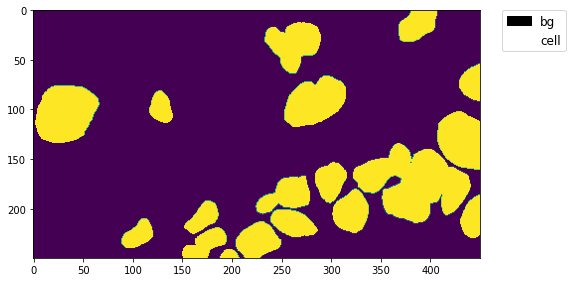

In [8]:
# Let's take a look at the segmentation map we got

img = Image.open('segmentation/annotations/image003-2-roi1.tif')
plt.figure(figsize=(8, 6))
im = plt.imshow(np.array(img))

# create a patch (proxy artist) for every color 
patches = [mpatches.Patch(color=np.array(palette[i])/255., 
                          label=classes[i]) for i in range(2)]
# put those patched as legend-handles into the legend
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., 
           fontsize='large')

plt.show()

In [9]:
# split train/val set randomly
split_dir = 'splits'
mmcv.mkdir_or_exist(osp.join(data_root, split_dir))
filename_list = [osp.splitext(filename)[0] for filename in mmcv.scandir(osp.join(data_root, ann_dir), suffix='.tif')]
with open(osp.join(data_root, split_dir, 'train.txt'), 'w') as f:
    # select first 4/5 as train set
    train_length = int(len(filename_list)*4/5)
    f.writelines(line + '\n' for line in filename_list[:train_length])
with open(osp.join(data_root, split_dir, 'val.txt'), 'w') as f:
    # select last 1/5 as train set
    f.writelines(line + '\n' for line in filename_list[train_length:])

In [10]:
@DATASETS.register_module()
class DysplasiaDataSet(CustomDataset):
    CLASSES = classes
    PALETTE = palette
    def __init__(self, split, **kwargs):
        super().__init__(img_suffix='.jpg', seg_map_suffix='.tif', split=split, **kwargs)
        assert osp.exists(self.img_dir) and self.split is not None

In [11]:
cfg = Config.fromfile('../models/pspnet_unet.py')

In [12]:
# Let's have a look at the final config used for training
print(f'Config:\n{cfg.pretty_text}')

Config:
dataset_type = 'DysplasiaDataSet'
data_root = 'segmentation'
img_norm_cfg = dict(
    mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=True)
crop_size = (256, 256)
train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations'),
    dict(type='Resize', img_scale=(320, 240), ratio_range=(0.5, 2.0)),
    dict(type='RandomCrop', crop_size=(256, 256), cat_max_ratio=0.75),
    dict(type='RandomFlip', flip_ratio=0.5),
    dict(type='PhotoMetricDistortion'),
    dict(
        type='Normalize',
        mean=[123.675, 116.28, 103.53],
        std=[58.395, 57.12, 57.375],
        to_rgb=True),
    dict(type='Pad', size=(256, 256), pad_val=0, seg_pad_val=255),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_semantic_seg'])
]
test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(
        type='MultiScaleFlipAug',
        img_scale=(256, 256),
        flip=False,
        transforms=[
            dict(type='R

In [13]:
datasets = [build_dataset(cfg.data.train)]

2022-02-14 20:50:29,287 - mmseg - INFO - Loaded 96 images


In [14]:
# Build the detector
model = build_segmentor(
    cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES

In [15]:
# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_segmentor(model, datasets, cfg, distributed=False, validate=True, meta=dict())

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
2022-02-14 20:50:33,919 - mmseg - INFO - Loaded 24 images
2022-02-14 20:50:33,923 - mmseg - INFO - Start running, host: root@bbb6c598e1f4, work_dir: /content/tcc/mmsegmentation/work_dirs/unet
2022-02-14 20:50:33,926 - mmseg - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) PolyLrUpdaterHook                  
(NORMAL      ) CheckpointHook                     
(LOW         ) EvalHook                           
(VERY_LOW    ) TextLoggerHook                     
 -------------------- 
before_train_epoch:
(VERY

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 15.4 task/s, elapsed: 2s, ETA:     0s

2022-02-14 20:50:46,992 - mmseg - INFO - per class results:
2022-02-14 20:50:46,998 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 83.35 | 99.86 |
|  cell |  1.5  |  0.76 |
+-------+-------+-------+
2022-02-14 20:50:47,002 - mmseg - INFO - Summary:
2022-02-14 20:50:47,007 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 71.52 | 42.43 | 50.31 |
+-------+-------+-------+
2022-02-14 20:50:47,011 - mmseg - INFO - Epoch(val) [1][24]	aAcc: 0.7152, mDice: 0.4243, mAcc: 0.5031, Dice.bg: 0.8335, Dice.cell: 0.0150, Acc.bg: 0.9986, Acc.cell: 0.0076
2022-02-14 20:50:58,152 - mmseg - INFO - Epoch [2][12/12]	lr: 9.553e-03, eta: 0:03:13, time: 0.883, data_time: 0.195, memory: 5172, decode.loss_ce: 0.4593, decode.acc_seg: 69.2445, aux.loss_ce: 0.1827, aux.acc_seg: 70.1789, loss: 0.6419


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 29.6 task/s, elapsed: 1s, ETA:     0s

2022-02-14 20:50:58,972 - mmseg - INFO - per class results:
2022-02-14 20:50:58,975 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 84.24 | 99.51 |
|  cell | 15.01 |  8.22 |
+-------+-------+-------+
2022-02-14 20:50:58,977 - mmseg - INFO - Summary:
2022-02-14 20:50:58,982 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 73.41 | 49.63 | 53.86 |
+-------+-------+-------+
2022-02-14 20:50:58,984 - mmseg - INFO - Epoch(val) [2][24]	aAcc: 0.7341, mDice: 0.4963, mAcc: 0.5386, Dice.bg: 0.8424, Dice.cell: 0.1501, Acc.bg: 0.9951, Acc.cell: 0.0822
2022-02-14 20:51:10,144 - mmseg - INFO - Epoch [3][12/12]	lr: 9.104e-03, eta: 0:03:02, time: 0.885, data_time: 0.195, memory: 5172, decode.loss_ce: 0.4417, decode.acc_seg: 71.3415, aux.loss_ce: 0.1783, aux.acc_seg: 71.3715, loss: 0.6200


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 28.6 task/s, elapsed: 1s, ETA:     0s

2022-02-14 20:51:10,993 - mmseg - INFO - per class results:
2022-02-14 20:51:10,994 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 85.51 | 98.27 |
|  cell |  33.7 | 21.14 |
+-------+-------+-------+
2022-02-14 20:51:10,997 - mmseg - INFO - Summary:
2022-02-14 20:51:11,001 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 76.21 |  59.6 | 59.71 |
+-------+-------+-------+
2022-02-14 20:51:11,004 - mmseg - INFO - Epoch(val) [3][24]	aAcc: 0.7621, mDice: 0.5960, mAcc: 0.5971, Dice.bg: 0.8551, Dice.cell: 0.3370, Acc.bg: 0.9827, Acc.cell: 0.2114
2022-02-14 20:51:22,099 - mmseg - INFO - Epoch [4][12/12]	lr: 8.653e-03, eta: 0:02:50, time: 0.879, data_time: 0.188, memory: 5172, decode.loss_ce: 0.3960, decode.acc_seg: 74.0377, aux.loss_ce: 0.1638, aux.acc_seg: 73.7503, loss: 0.5599


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 28.7 task/s, elapsed: 1s, ETA:     0s

2022-02-14 20:51:22,943 - mmseg - INFO - per class results:
2022-02-14 20:51:22,945 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  |  87.0 |  94.8 |
|  cell | 54.41 | 42.23 |
+-------+-------+-------+
2022-02-14 20:51:22,946 - mmseg - INFO - Summary:
2022-02-14 20:51:22,948 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 79.76 |  70.7 | 68.51 |
+-------+-------+-------+
2022-02-14 20:51:22,951 - mmseg - INFO - Epoch(val) [4][24]	aAcc: 0.7976, mDice: 0.7070, mAcc: 0.6851, Dice.bg: 0.8700, Dice.cell: 0.5441, Acc.bg: 0.9480, Acc.cell: 0.4223
2022-02-14 20:51:34,060 - mmseg - INFO - Epoch [5][12/12]	lr: 8.199e-03, eta: 0:02:39, time: 0.880, data_time: 0.188, memory: 5172, decode.loss_ce: 0.3996, decode.acc_seg: 76.9666, aux.loss_ce: 0.1648, aux.acc_seg: 76.1945, loss: 0.5644


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 28.0 task/s, elapsed: 1s, ETA:     0s

2022-02-14 20:51:34,926 - mmseg - INFO - per class results:
2022-02-14 20:51:34,927 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 87.19 | 90.37 |
|  cell | 63.54 | 57.76 |
+-------+-------+-------+
2022-02-14 20:51:34,929 - mmseg - INFO - Summary:
2022-02-14 20:51:34,935 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 81.04 | 75.37 | 74.07 |
+-------+-------+-------+
2022-02-14 20:51:34,938 - mmseg - INFO - Epoch(val) [5][24]	aAcc: 0.8104, mDice: 0.7537, mAcc: 0.7407, Dice.bg: 0.8719, Dice.cell: 0.6354, Acc.bg: 0.9037, Acc.cell: 0.5776
2022-02-14 20:51:46,122 - mmseg - INFO - Epoch [6][12/12]	lr: 7.742e-03, eta: 0:02:29, time: 0.886, data_time: 0.192, memory: 5172, decode.loss_ce: 0.3581, decode.acc_seg: 77.7856, aux.loss_ce: 0.1483, aux.acc_seg: 76.9598, loss: 0.5064


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 29.4 task/s, elapsed: 1s, ETA:     0s

2022-02-14 20:51:46,948 - mmseg - INFO - per class results:
2022-02-14 20:51:46,950 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 87.31 | 88.19 |
|  cell | 67.19 | 65.51 |
+-------+-------+-------+
2022-02-14 20:51:46,951 - mmseg - INFO - Summary:
2022-02-14 20:51:46,954 - mmseg - INFO - 
+------+-------+-------+
| aAcc | mDice |  mAcc |
+------+-------+-------+
| 81.7 | 77.25 | 76.85 |
+------+-------+-------+
2022-02-14 20:51:46,959 - mmseg - INFO - Epoch(val) [6][24]	aAcc: 0.8170, mDice: 0.7725, mAcc: 0.7685, Dice.bg: 0.8731, Dice.cell: 0.6719, Acc.bg: 0.8819, Acc.cell: 0.6551
2022-02-14 20:51:58,184 - mmseg - INFO - Epoch [7][12/12]	lr: 7.282e-03, eta: 0:02:18, time: 0.890, data_time: 0.194, memory: 5172, decode.loss_ce: 0.3580, decode.acc_seg: 78.6180, aux.loss_ce: 0.1474, aux.acc_seg: 77.4422, loss: 0.5054


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 27.6 task/s, elapsed: 1s, ETA:     0s

2022-02-14 20:51:59,062 - mmseg - INFO - per class results:
2022-02-14 20:51:59,063 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 87.12 | 86.13 |
|  cell | 69.07 | 71.02 |
+-------+-------+-------+
2022-02-14 20:51:59,065 - mmseg - INFO - Summary:
2022-02-14 20:51:59,069 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 81.81 | 78.09 | 78.57 |
+-------+-------+-------+
2022-02-14 20:51:59,072 - mmseg - INFO - Epoch(val) [7][24]	aAcc: 0.8181, mDice: 0.7809, mAcc: 0.7857, Dice.bg: 0.8712, Dice.cell: 0.6907, Acc.bg: 0.8613, Acc.cell: 0.7102
2022-02-14 20:52:10,312 - mmseg - INFO - Epoch [8][12/12]	lr: 6.818e-03, eta: 0:02:07, time: 0.891, data_time: 0.194, memory: 5172, decode.loss_ce: 0.3586, decode.acc_seg: 79.2385, aux.loss_ce: 0.1463, aux.acc_seg: 78.2566, loss: 0.5049


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 28.5 task/s, elapsed: 1s, ETA:     0s

2022-02-14 20:52:11,165 - mmseg - INFO - per class results:
2022-02-14 20:52:11,167 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 85.41 | 81.36 |
|  cell | 68.97 | 77.14 |
+-------+-------+-------+
2022-02-14 20:52:11,169 - mmseg - INFO - Summary:
2022-02-14 20:52:11,174 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 80.15 | 77.19 | 79.25 |
+-------+-------+-------+
2022-02-14 20:52:11,179 - mmseg - INFO - Epoch(val) [8][24]	aAcc: 0.8015, mDice: 0.7719, mAcc: 0.7925, Dice.bg: 0.8541, Dice.cell: 0.6897, Acc.bg: 0.8136, Acc.cell: 0.7714
2022-02-14 20:52:22,415 - mmseg - INFO - Epoch [9][12/12]	lr: 6.351e-03, eta: 0:01:57, time: 0.890, data_time: 0.193, memory: 5172, decode.loss_ce: 0.3460, decode.acc_seg: 79.5102, aux.loss_ce: 0.1414, aux.acc_seg: 78.4570, loss: 0.4874


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 29.0 task/s, elapsed: 1s, ETA:     0s

2022-02-14 20:52:23,257 - mmseg - INFO - per class results:
2022-02-14 20:52:23,260 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 85.99 | 82.23 |
|  cell | 69.83 | 77.45 |
+-------+-------+-------+
2022-02-14 20:52:23,261 - mmseg - INFO - Summary:
2022-02-14 20:52:23,265 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 80.86 | 77.91 | 79.84 |
+-------+-------+-------+
2022-02-14 20:52:23,268 - mmseg - INFO - Epoch(val) [9][24]	aAcc: 0.8086, mDice: 0.7791, mAcc: 0.7984, Dice.bg: 0.8599, Dice.cell: 0.6983, Acc.bg: 0.8223, Acc.cell: 0.7745
2022-02-14 20:52:34,573 - mmseg - INFO - Epoch [10][12/12]	lr: 5.880e-03, eta: 0:01:46, time: 0.896, data_time: 0.195, memory: 5172, decode.loss_ce: 0.3347, decode.acc_seg: 80.0392, aux.loss_ce: 0.1376, aux.acc_seg: 78.9478, loss: 0.4723
2022-02-14 20:52:34,575 - mmseg - INFO - Saving checkpoint at 10 epochs


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 27.5 task/s, elapsed: 1s, ETA:     0s

2022-02-14 20:52:36,845 - mmseg - INFO - per class results:
2022-02-14 20:52:36,847 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 88.06 | 87.39 |
|  cell | 70.95 | 72.29 |
+-------+-------+-------+
2022-02-14 20:52:36,848 - mmseg - INFO - Summary:
2022-02-14 20:52:36,856 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 83.07 |  79.5 | 79.84 |
+-------+-------+-------+
2022-02-14 20:52:36,859 - mmseg - INFO - Epoch(val) [10][24]	aAcc: 0.8307, mDice: 0.7950, mAcc: 0.7984, Dice.bg: 0.8806, Dice.cell: 0.7095, Acc.bg: 0.8739, Acc.cell: 0.7229
2022-02-14 20:52:48,121 - mmseg - INFO - Epoch [11][12/12]	lr: 5.405e-03, eta: 0:01:36, time: 0.892, data_time: 0.191, memory: 5172, decode.loss_ce: 0.3364, decode.acc_seg: 80.0009, aux.loss_ce: 0.1380, aux.acc_seg: 79.1742, loss: 0.4744


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 28.6 task/s, elapsed: 1s, ETA:     0s

2022-02-14 20:52:48,970 - mmseg - INFO - per class results:
2022-02-14 20:52:48,972 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 88.06 | 86.36 |
|  cell | 72.09 | 75.56 |
+-------+-------+-------+
2022-02-14 20:52:48,976 - mmseg - INFO - Summary:
2022-02-14 20:52:48,978 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 83.27 | 80.07 | 80.96 |
+-------+-------+-------+
2022-02-14 20:52:48,982 - mmseg - INFO - Epoch(val) [11][24]	aAcc: 0.8327, mDice: 0.8007, mAcc: 0.8096, Dice.bg: 0.8806, Dice.cell: 0.7209, Acc.bg: 0.8636, Acc.cell: 0.7556
2022-02-14 20:53:00,452 - mmseg - INFO - Epoch [12][12/12]	lr: 4.925e-03, eta: 0:01:25, time: 0.910, data_time: 0.207, memory: 5172, decode.loss_ce: 0.3575, decode.acc_seg: 80.7348, aux.loss_ce: 0.1460, aux.acc_seg: 79.6358, loss: 0.5034


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 16.5 task/s, elapsed: 1s, ETA:     0s

2022-02-14 20:53:01,938 - mmseg - INFO - per class results:
2022-02-14 20:53:01,940 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 86.97 |  83.2 |
|  cell | 71.92 | 79.72 |
+-------+-------+-------+
2022-02-14 20:53:01,946 - mmseg - INFO - Summary:
2022-02-14 20:53:01,951 - mmseg - INFO - 
+------+-------+-------+
| aAcc | mDice |  mAcc |
+------+-------+-------+
| 82.2 | 79.45 | 81.46 |
+------+-------+-------+
2022-02-14 20:53:01,953 - mmseg - INFO - Epoch(val) [12][24]	aAcc: 0.8220, mDice: 0.7945, mAcc: 0.8146, Dice.bg: 0.8697, Dice.cell: 0.7192, Acc.bg: 0.8320, Acc.cell: 0.7972
2022-02-14 20:53:13,244 - mmseg - INFO - Epoch [13][12/12]	lr: 4.440e-03, eta: 0:01:14, time: 0.894, data_time: 0.191, memory: 5172, decode.loss_ce: 0.3617, decode.acc_seg: 80.4088, aux.loss_ce: 0.1472, aux.acc_seg: 79.8063, loss: 0.5089


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 28.2 task/s, elapsed: 1s, ETA:     0s

2022-02-14 20:53:14,102 - mmseg - INFO - per class results:
2022-02-14 20:53:14,104 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 86.03 | 81.31 |
|  cell |  71.0 | 80.72 |
+-------+-------+-------+
2022-02-14 20:53:14,106 - mmseg - INFO - Summary:
2022-02-14 20:53:14,109 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 81.14 | 78.51 | 81.01 |
+-------+-------+-------+
2022-02-14 20:53:14,116 - mmseg - INFO - Epoch(val) [13][24]	aAcc: 0.8114, mDice: 0.7851, mAcc: 0.8101, Dice.bg: 0.8603, Dice.cell: 0.7100, Acc.bg: 0.8131, Acc.cell: 0.8072
2022-02-14 20:53:25,384 - mmseg - INFO - Epoch [14][12/12]	lr: 3.949e-03, eta: 0:01:04, time: 0.893, data_time: 0.189, memory: 5172, decode.loss_ce: 0.3484, decode.acc_seg: 81.0424, aux.loss_ce: 0.1415, aux.acc_seg: 80.0483, loss: 0.4899


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 28.6 task/s, elapsed: 1s, ETA:     0s

2022-02-14 20:53:26,230 - mmseg - INFO - per class results:
2022-02-14 20:53:26,231 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 86.91 |  83.0 |
|  cell | 71.95 | 80.03 |
+-------+-------+-------+
2022-02-14 20:53:26,233 - mmseg - INFO - Summary:
2022-02-14 20:53:26,235 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 82.15 | 79.43 | 81.52 |
+-------+-------+-------+
2022-02-14 20:53:26,242 - mmseg - INFO - Epoch(val) [14][24]	aAcc: 0.8215, mDice: 0.7943, mAcc: 0.8152, Dice.bg: 0.8691, Dice.cell: 0.7195, Acc.bg: 0.8300, Acc.cell: 0.8003
2022-02-14 20:53:37,498 - mmseg - INFO - Epoch [15][12/12]	lr: 3.450e-03, eta: 0:00:53, time: 0.892, data_time: 0.187, memory: 5172, decode.loss_ce: 0.3257, decode.acc_seg: 81.2840, aux.loss_ce: 0.1324, aux.acc_seg: 80.5960, loss: 0.4581


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 28.6 task/s, elapsed: 1s, ETA:     0s

2022-02-14 20:53:38,345 - mmseg - INFO - per class results:
2022-02-14 20:53:38,347 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 86.26 |  81.4 |
|  cell | 71.61 | 81.67 |
+-------+-------+-------+
2022-02-14 20:53:38,349 - mmseg - INFO - Summary:
2022-02-14 20:53:38,350 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 81.48 | 78.93 | 81.54 |
+-------+-------+-------+
2022-02-14 20:53:38,352 - mmseg - INFO - Epoch(val) [15][24]	aAcc: 0.8148, mDice: 0.7893, mAcc: 0.8154, Dice.bg: 0.8626, Dice.cell: 0.7161, Acc.bg: 0.8140, Acc.cell: 0.8167
2022-02-14 20:53:49,656 - mmseg - INFO - Epoch [16][12/12]	lr: 2.943e-03, eta: 0:00:42, time: 0.896, data_time: 0.192, memory: 5172, decode.loss_ce: 0.3262, decode.acc_seg: 81.2961, aux.loss_ce: 0.1303, aux.acc_seg: 80.9422, loss: 0.4565


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 28.5 task/s, elapsed: 1s, ETA:     0s

2022-02-14 20:53:50,509 - mmseg - INFO - per class results:
2022-02-14 20:53:50,511 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  |  86.5 | 82.33 |
|  cell | 71.38 | 79.97 |
+-------+-------+-------+
2022-02-14 20:53:50,513 - mmseg - INFO - Summary:
2022-02-14 20:53:50,516 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 81.66 | 78.94 | 81.15 |
+-------+-------+-------+
2022-02-14 20:53:50,518 - mmseg - INFO - Epoch(val) [16][24]	aAcc: 0.8166, mDice: 0.7894, mAcc: 0.8115, Dice.bg: 0.8650, Dice.cell: 0.7138, Acc.bg: 0.8233, Acc.cell: 0.7997
2022-02-14 20:54:01,813 - mmseg - INFO - Epoch [17][12/12]	lr: 2.426e-03, eta: 0:00:32, time: 0.895, data_time: 0.191, memory: 5172, decode.loss_ce: 0.3339, decode.acc_seg: 81.5055, aux.loss_ce: 0.1382, aux.acc_seg: 80.4744, loss: 0.4721


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 28.8 task/s, elapsed: 1s, ETA:     0s

2022-02-14 20:54:02,658 - mmseg - INFO - per class results:
2022-02-14 20:54:02,659 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 87.43 | 84.64 |
|  cell | 71.86 |  77.6 |
+-------+-------+-------+
2022-02-14 20:54:02,661 - mmseg - INFO - Summary:
2022-02-14 20:54:02,663 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 82.62 | 79.65 | 81.12 |
+-------+-------+-------+
2022-02-14 20:54:02,671 - mmseg - INFO - Epoch(val) [17][24]	aAcc: 0.8262, mDice: 0.7965, mAcc: 0.8112, Dice.bg: 0.8743, Dice.cell: 0.7186, Acc.bg: 0.8464, Acc.cell: 0.7760
2022-02-14 20:54:13,969 - mmseg - INFO - Epoch [18][12/12]	lr: 1.895e-03, eta: 0:00:21, time: 0.895, data_time: 0.191, memory: 5172, decode.loss_ce: 0.3340, decode.acc_seg: 80.5540, aux.loss_ce: 0.1371, aux.acc_seg: 79.6566, loss: 0.4711


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 28.0 task/s, elapsed: 1s, ETA:     0s

2022-02-14 20:54:14,835 - mmseg - INFO - per class results:
2022-02-14 20:54:14,837 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 86.99 | 82.62 |
|  cell |  72.6 | 81.73 |
+-------+-------+-------+
2022-02-14 20:54:14,840 - mmseg - INFO - Summary:
2022-02-14 20:54:14,843 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 82.36 |  79.8 | 82.17 |
+-------+-------+-------+
2022-02-14 20:54:14,845 - mmseg - INFO - Epoch(val) [18][24]	aAcc: 0.8236, mDice: 0.7980, mAcc: 0.8217, Dice.bg: 0.8699, Dice.cell: 0.7260, Acc.bg: 0.8262, Acc.cell: 0.8173
2022-02-14 20:54:26,089 - mmseg - INFO - Epoch [19][12/12]	lr: 1.346e-03, eta: 0:00:10, time: 0.890, data_time: 0.185, memory: 5172, decode.loss_ce: 0.3079, decode.acc_seg: 82.1662, aux.loss_ce: 0.1271, aux.acc_seg: 81.2932, loss: 0.4351


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 28.2 task/s, elapsed: 1s, ETA:     0s

2022-02-14 20:54:26,949 - mmseg - INFO - per class results:
2022-02-14 20:54:26,950 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 87.46 | 84.26 |
|  cell | 72.35 | 78.96 |
+-------+-------+-------+
2022-02-14 20:54:26,951 - mmseg - INFO - Summary:
2022-02-14 20:54:26,954 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 82.74 |  79.9 | 81.61 |
+-------+-------+-------+
2022-02-14 20:54:26,963 - mmseg - INFO - Epoch(val) [19][24]	aAcc: 0.8274, mDice: 0.7990, mAcc: 0.8161, Dice.bg: 0.8746, Dice.cell: 0.7235, Acc.bg: 0.8426, Acc.cell: 0.7896
2022-02-14 20:54:38,283 - mmseg - INFO - Epoch [20][12/12]	lr: 7.679e-04, eta: 0:00:00, time: 0.897, data_time: 0.192, memory: 5172, decode.loss_ce: 0.3205, decode.acc_seg: 81.5105, aux.loss_ce: 0.1312, aux.acc_seg: 80.6026, loss: 0.4516
2022-02-14 20:54:38,285 - mmseg - INFO - Saving checkpoint at 20 epochs


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 27.5 task/s, elapsed: 1s, ETA:     0s

2022-02-14 20:54:40,240 - mmseg - INFO - per class results:
2022-02-14 20:54:40,241 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  |  87.5 | 84.22 |
|  cell | 72.53 | 79.31 |
+-------+-------+-------+
2022-02-14 20:54:40,242 - mmseg - INFO - Summary:
2022-02-14 20:54:40,247 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 82.82 | 80.01 | 81.77 |
+-------+-------+-------+
2022-02-14 20:54:40,250 - mmseg - INFO - Epoch(val) [20][24]	aAcc: 0.8282, mDice: 0.8001, mAcc: 0.8177, Dice.bg: 0.8750, Dice.cell: 0.7253, Acc.bg: 0.8422, Acc.cell: 0.7931


/content/tcc/mmsegmentation/mmseg/models/segmentors/base.py:284: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


<Figure size 576x432 with 0 Axes>

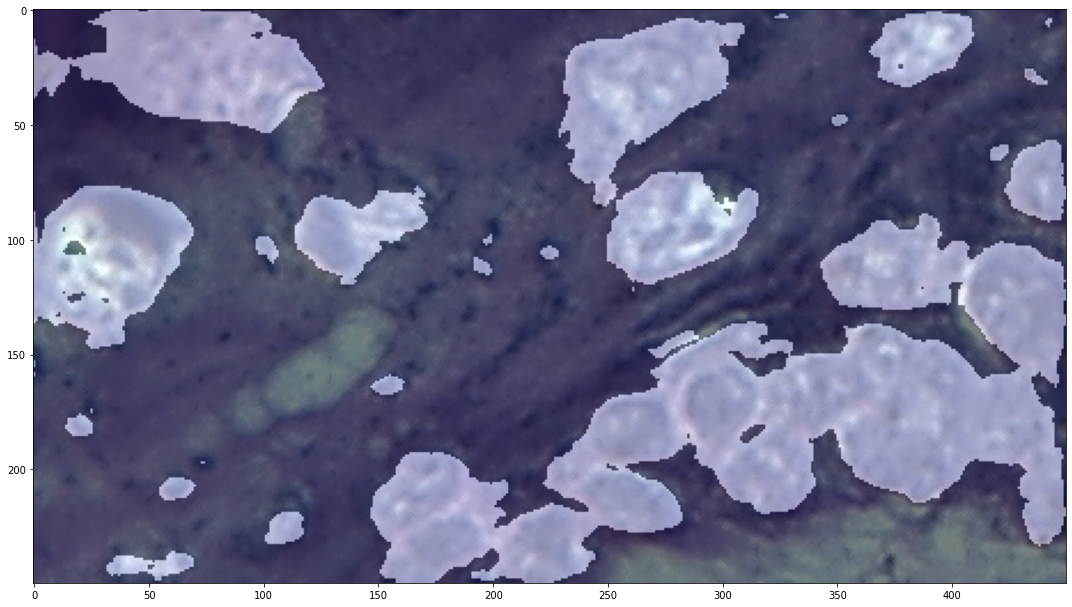

In [16]:
from mmseg.apis import inference_segmentor, show_result_pyplot
img = mmcv.imread('segmentation/images/image003-2-roi1.jpg')

model.cfg = cfg
result = inference_segmentor(model, img)
plt.figure(figsize=(8, 6))
show_result_pyplot(model, img, result, palette)

/content/tcc/mmsegmentation/mmseg/models/segmentors/base.py:284: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


<Figure size 576x432 with 0 Axes>

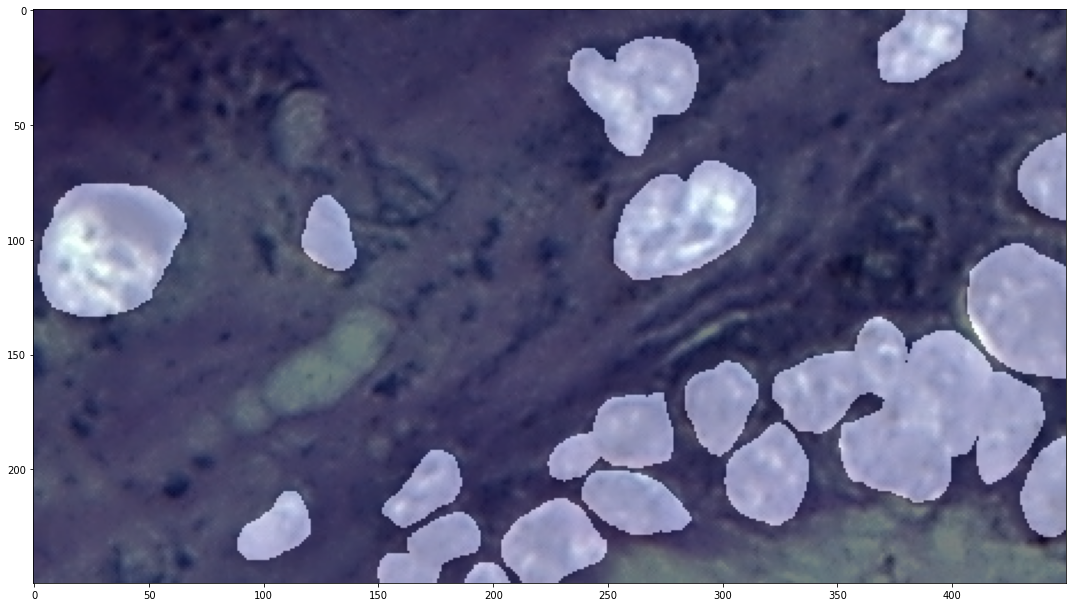

In [17]:
from mmseg.apis import inference_segmentor, show_result_pyplot
img = mmcv.imread('segmentation/images/image003-2-roi1.jpg')
result = mmcv.imread('segmentation/annotations/image003-2-roi1.tif',flag='grayscale')

model.cfg = cfg
# result = inference_segmentor(model, img)
plt.figure(figsize=(8, 6))
show_result_pyplot(model, img, [result], palette)

/content/tcc/mmsegmentation/mmseg/models/segmentors/base.py:284: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


<Figure size 576x432 with 0 Axes>

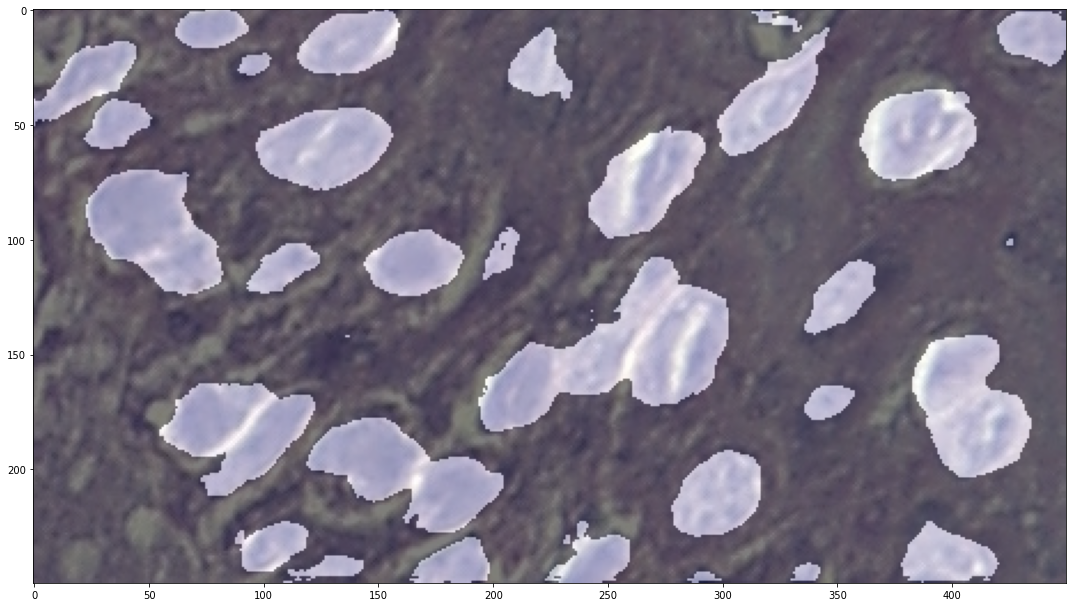

In [18]:
from mmseg.apis import inference_segmentor, show_result_pyplot
img = mmcv.imread('segmentation/images/image037-roi4.jpg')

model.cfg = cfg
result = inference_segmentor(model, img)
plt.figure(figsize=(8, 6))
show_result_pyplot(model, img, result, palette)

/content/tcc/mmsegmentation/mmseg/models/segmentors/base.py:284: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


<Figure size 576x432 with 0 Axes>

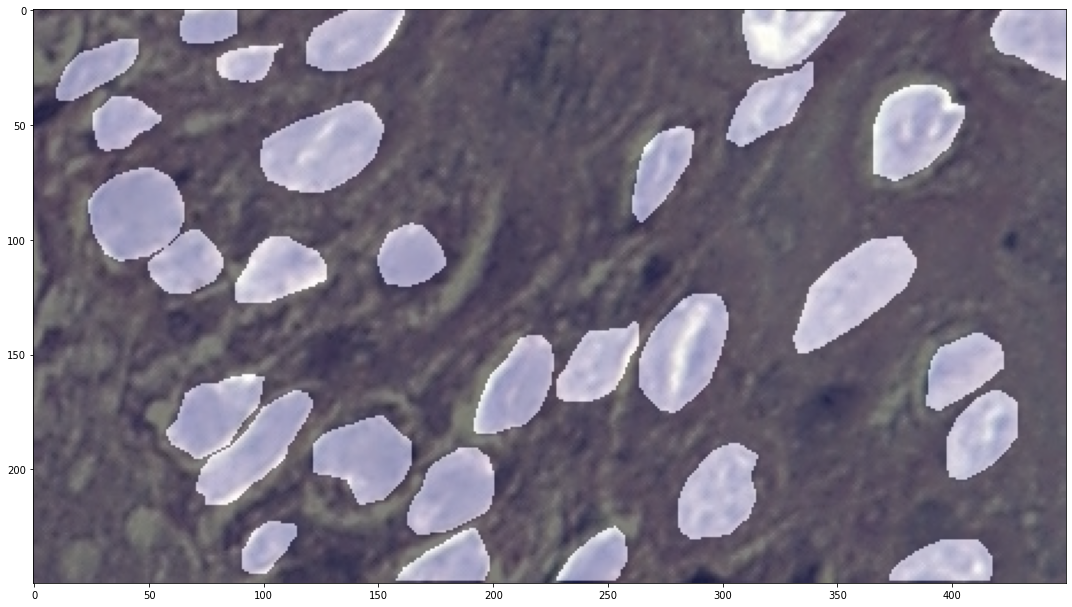

In [19]:
from mmseg.apis import inference_segmentor, show_result_pyplot
img = mmcv.imread('segmentation/images/image037-roi4.jpg')
result = mmcv.imread('segmentation/annotations/image037-roi4.tif',flag='grayscale')

model.cfg = cfg
# result = inference_segmentor(model, img)
plt.figure(figsize=(8, 6))
show_result_pyplot(model, img, [result], palette)

In [21]:
%matplotlib inline
import json

file = open('./work_dirs/unet/None.log.json')
lines = file.readlines()

m_dice = []
m_acc = []
loss = []

for line in lines:
    json_line = json.loads(line)
    if len(json_line):
        if json_line['mode'] == 'train':
            loss.append(json_line['loss'])
        else:
            m_acc.append(json_line['mAcc'])
            m_dice.append(json_line['mDice'])

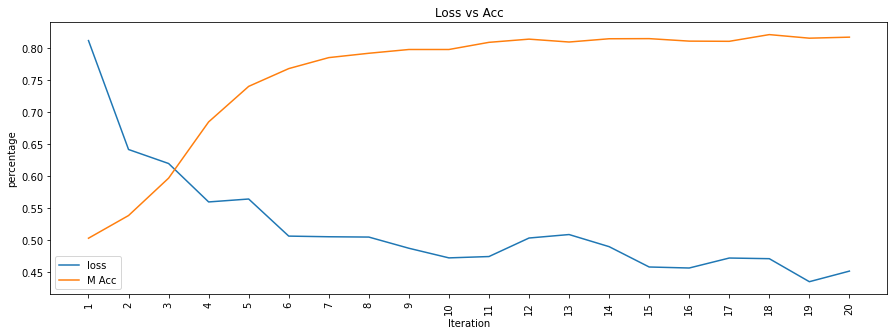

In [22]:
plt.figure(figsize=(15, 5))
plt.plot(range(1, len(m_acc) + 1), loss, label="loss")
plt.plot(range(1, len(m_acc) + 1), m_acc, label="M Acc")
plt.xticks(range(1, len(m_acc) + 1), rotation=90)
plt.title("Loss vs Acc")
plt.xlabel("Iteration")
plt.ylabel("percentage")
plt.legend()
plt.savefig('Loss_vs_Acc_Graph.png')
plt.show()

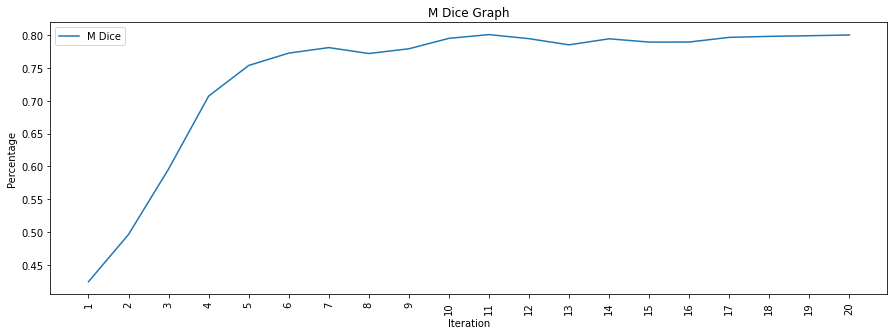

In [23]:
plt.figure(figsize=(15, 5))
plt.plot(range(1, len(m_acc) + 1), m_dice, label="M Dice")
plt.xticks(range(1, len(m_acc) + 1), rotation=90)
plt.title("M Dice Graph")
plt.xlabel("Iteration")
plt.ylabel("Percentage")
plt.legend()
plt.savefig('M_Dice_Graph.png')
plt.show()
plt.close()